In [1]:
import einops
import numpy as np
import torch
from torch import nn, optim
import gymnasium as gym
import ale_py

/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/ale_py/__init__.py", line 66, in <module>
    register_v0_v4_envs()
  File "/home/fitti/.conda/envs/puffer/lib/python3.11/site-packages/ale_py/registration.py", line 176, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/home/fitti/.conda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make("ALE/Breakout-v5")

A.L.E: Arcade Learning Environment (version 0.9.0+750d7f9)
[Powered by Stella]


In [4]:
ob, _ = env.reset()
ob = einops.rearrange(ob, "h w c -> c h w")
frames = [ob]
done, truncated = False, False
while not (done or truncated):
    ob, _, done, truncated, _ = env.step(env.action_space.sample())
    ob = einops.rearrange(ob, "h w c -> c h w")
    frames.append(ob.copy())

In [5]:
frames = torch.tensor(np.array(frames) / 255.0, dtype=torch.float32, device=device)
frames.shape

torch.Size([136, 3, 210, 160])

In [6]:
ob_shape = frames[0].shape
ob_shape

torch.Size([3, 210, 160])

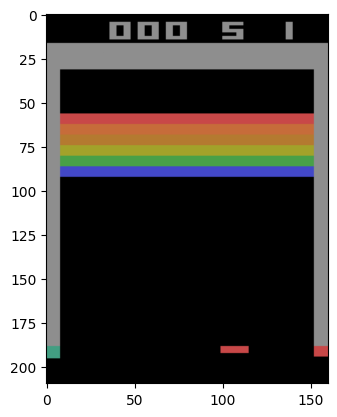

In [7]:
import matplotlib.pyplot as plt

plt.imshow(frames[0].cpu().permute(1, 2, 0))

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_channels, second_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, first_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(first_channels, second_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(second_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

    def forward(self, x):
        return self.encoder(x)

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, first_channels, second_channels, out_channels, out_size=None):
        super().__init__()
        if out_size:
            upsampler = nn.UpsamplingBilinear2d(size=out_size)
        else:
            upsampler = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decoder = nn.Sequential(
            upsampler,
            nn.Conv2d(in_channels, first_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(first_channels, second_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(second_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.decoder(x)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, ob_shape):
        super().__init__()
        c, h, w = ob_shape

        self.encoder = nn.Sequential(
            EncoderBlock(c, 16, 32, 64),
            EncoderBlock(64, 64, 128, 128),
            EncoderBlock(128, 128, 64, 64),
        )

        self.decoder = nn.Sequential(
            DecoderBlock(64, 64, 128, 128),
            DecoderBlock(128, 128, 64, 64),
            DecoderBlock(64, 32, 16, c, out_size=[h, w]),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [11]:
net = Autoencoder(ob_shape).to(device=device)
sum(p.numel() for p in net.parameters())

In [12]:
with torch.no_grad():
    pred = net(frames[0:1])
pred.shape

torch.Size([1, 3, 210, 160])

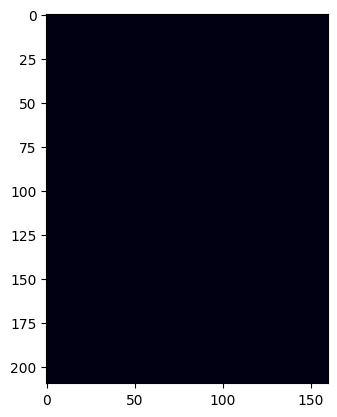

In [13]:
img = einops.rearrange(pred[0], "c h w -> h w c")
plt.imshow(img.cpu())

In [14]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [15]:
num_epochs = 5_000
batch_size = 16
frames = frames[:64]
num_batches = len(frames) // batch_size

In [16]:
from tqdm.auto import tqdm

In [ ]:
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    indices = torch.randperm(len(frames))
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_data = frames[batch_indices]
        
        preds = net(batch_data)
        loss = loss_fn(preds, batch_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    preds = net(frames)
preds.shape, frames.shape

In [ ]:
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()

indices = torch.randperm(len(frames))[:5]

for i, ax in enumerate(axes[:5]):
    img = einops.rearrange(preds[indices[i]], "c h w -> h w c")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.cpu())
    
for i, ax in enumerate(axes[5:]):
    img = einops.rearrange(frames[indices[i]], "c h w -> h w c")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.cpu())

plt.tight_layout()
plt.show()